In [1]:
import torch
from torch_geometric.data import InMemoryDataset, download_url
import pandas as pd

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

import numpy as np
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt

# Data loading and preparation

In [2]:
edges = pd.read_csv("../data/interim/edges.csv")

In [3]:
noisy = pd.read_csv("../data/interim/noisy_cells.csv")

In [4]:
noisy =  noisy["cell.names"]

In [8]:
edges = edges[~edges.node1.isin(noisy)]

In [5]:
edges[edges.type == "sc2vis"][edges[edges.type == "sc2vis"].celltype_major.isna()]

Empty DataFrame
Columns: [Unnamed: 0, node1, node2, type, celltype_major, celltype_minor, clone]
Index: []

In [6]:
overcl = pd.read_csv("../data/interim/clones.csv")

In [7]:
overcl.columns = ["node1","clone"]

In [8]:
overcl.clone.unique()

array(['3', '5', 'diploid', '2', '6', '7', '1', '0', '4'], dtype=object)

In [9]:
edges = edges.drop(columns = ["clone"])


In [10]:
overcl = edges[edges["type"] == "sc2vis"].merge(overcl,left_on = "node1",right_on ="node1",how = "left")

In [11]:
overcl.clone = overcl.clone.fillna("diploid")

In [12]:
overcl.clone.unique()

array(['diploid', '0', '3', '7', '1', '5', '6', '2', '4'], dtype=object)

In [13]:
edges= edges.merge(overcl[["clone","node1"]],left_on = "node1",right_on ="node1",how = "left")

In [14]:
emb_vis = pd.read_csv("../data/interim/embedding_visium_scvi.csv", index_col = 0)
emb_rna = pd.read_csv("../data/interim/embedding_rna2vis_scvi.csv", index_col = 0)

In [15]:
all_nodes_graph = set(edges.node1.to_list() + edges.node2.to_list())
all_nodes_emb = set(emb_vis.index).union(set(emb_rna.index))
all_nodes = list(all_nodes_graph.intersection(all_nodes_emb))
node_encoder = {all_nodes[i]:i for i in range(len(all_nodes))}
emb_vis = emb_vis.loc[emb_vis.index.isin(all_nodes)]
emb_rna = emb_rna.loc[emb_rna.index.isin(all_nodes)]

In [16]:
edges = edges[edges.node1.isin(all_nodes)]

In [17]:
edges = edges[edges.node2.isin(all_nodes)]

In [18]:
edges.node1 = edges.node1.map(node_encoder)

In [19]:
edges.node2 = edges.node2.map(node_encoder)

In [20]:
emb_vis = emb_vis.rename(index = node_encoder)
emb_rna = emb_rna.rename(index = node_encoder)

In [21]:
len(all_nodes)

34079

In [22]:
edge_index = torch.tensor([edges.node1,
                           edges.node2], dtype=torch.long)

In [23]:
features = pd.concat([emb_vis, emb_rna])

In [24]:
features = features.sort_index()

In [25]:
x = torch.tensor(features.values , dtype=torch.float)

In [26]:
edges[edges.type == "vis2grid"]

Unnamed: 0  node1  node2      type celltype_major celltype_minor  \
2908700      298910   8850  11380  vis2grid            NaN            NaN   
2908701      298911   8850  20650  vis2grid            NaN            NaN   
2908702      298912   2554   5612  vis2grid            NaN            NaN   
2908703      298913   2554  14381  vis2grid            NaN            NaN   
2908704      298914   2554  32973  vis2grid            NaN            NaN   
...             ...    ...    ...       ...            ...            ...   
2928253      318463  20004   7005  vis2grid            NaN            NaN   
2928254      318464  20004  14326  vis2grid            NaN            NaN   
2928255      318465  20004  23184  vis2grid            NaN            NaN   
2928256      318466   1435   8068  vis2grid            NaN            NaN   
2928257      318467   1435  15816  vis2grid            NaN            NaN   

        clone  
2908700   NaN  
2908701   NaN  
2908702   NaN  
2908703   NaN  
2908704   NaN  
...       ...  
2928253   NaN  
2928254   NaN  
2928255   NaN  
2928256   NaN  
2928257   NaN  

[19558 rows x 7 columns]

In [27]:
edges.clone = edges.clone.fillna("missing")

In [28]:
edges[edges.clone == "missing"]

Unnamed: 0  node1  node2      type celltype_major celltype_minor  \
2908700      298910   8850  11380  vis2grid            NaN            NaN   
2908701      298911   8850  20650  vis2grid            NaN            NaN   
2908702      298912   2554   5612  vis2grid            NaN            NaN   
2908703      298913   2554  14381  vis2grid            NaN            NaN   
2908704      298914   2554  32973  vis2grid            NaN            NaN   
...             ...    ...    ...       ...            ...            ...   
2928253      318463  20004   7005  vis2grid            NaN            NaN   
2928254      318464  20004  14326  vis2grid            NaN            NaN   
2928255      318465  20004  23184  vis2grid            NaN            NaN   
2928256      318466   1435   8068  vis2grid            NaN            NaN   
2928257      318467   1435  15816  vis2grid            NaN            NaN   

           clone  
2908700  missing  
2908701  missing  
2908702  missing  
2908703  missing  
2908704  missing  
...          ...  
2928253  missing  
2928254  missing  
2928255  missing  
2928256  missing  
2928257  missing  

[19558 rows x 7 columns]

In [29]:
nodes_atr = edges[["node1","type","celltype_major", "clone"]].drop_duplicates()

In [30]:
nodes_atr = nodes_atr.sort_values(by = "node1")

In [31]:
nodes_atr.clone.unique()

array(['diploid', 'missing', '1', '2', '7', '0', '5', '4', '3', '6'],
      dtype=object)

In [32]:
nodes_atr.celltype_major = nodes_atr.celltype_major.fillna("missing")

In [33]:
nodes_atr

node1      type     celltype_major    clone
2087900      0    sc2vis            T.cells  diploid
2912157      1  vis2grid            missing  missing
2606800      2    sc2vis            Myeloid  diploid
2242700      3    sc2vis            T.cells  diploid
1944600      4    sc2vis            Myeloid  diploid
...        ...       ...                ...      ...
2923954  34074  vis2grid            missing  missing
186100   34075    sc2vis            T.cells  diploid
502200   34076    sc2vis            Myeloid  diploid
2326600  34077    sc2vis  Normal Epithelial        7
1788000  34078    sc2vis            T.cells  diploid

[34079 rows x 4 columns]

In [34]:
from collections import Counter

Counter(nodes_atr.celltype_major)

Counter({'T.cells': 5983,
         'missing': 4992,
         'Myeloid': 3868,
         'Cancer Epithelial': 8503,
         'Normal Epithelial': 4033,
         'Endothelial': 1346,
         'CAFs': 2592,
         'B.cells': 1018,
         'PVL': 469,
         'Plasmablasts': 1275})

In [35]:
ct_list = list(nodes_atr.celltype_major.unique())
ct_list.remove("missing")

In [36]:
Counter(nodes_atr.clone)

Counter({'diploid': 19615,
         'missing': 4992,
         '1': 1953,
         '2': 1610,
         '7': 560,
         '0': 2673,
         '5': 808,
         '4': 846,
         '3': 462,
         '6': 560})

In [37]:
clone_list = list(nodes_atr.clone.unique())
clone_list.remove("missing")
clone_list.remove("diploid")
clone_dict = {x:int(x) for x in clone_list}
clone_dict["missing"] = -1
clone_dict["diploid"] = len(clone_dict)-1

In [38]:
clone_dict

{'1': 1,
 '2': 2,
 '7': 7,
 '0': 0,
 '5': 5,
 '4': 4,
 '3': 3,
 '6': 6,
 'missing': -1,
 'diploid': 8}

In [39]:
type_dict = {ct_list[i]:i for i in range(len(ct_list))}

In [40]:
type_dict["missing"] = -1

In [41]:
type_dict

{'T.cells': 0,
 'Myeloid': 1,
 'Cancer Epithelial': 2,
 'Normal Epithelial': 3,
 'Endothelial': 4,
 'CAFs': 5,
 'B.cells': 6,
 'PVL': 7,
 'Plasmablasts': 8,
 'missing': -1}

In [42]:
nodes_atr.clone = nodes_atr.clone.map(clone_dict)

In [43]:
edges.celltype_major = edges.celltype_major.fillna("missing")

In [44]:
nodes_atr.celltype_major = nodes_atr.celltype_major.map(type_dict)

In [45]:
nodes_atr = nodes_atr.set_index("node1")

In [46]:
nodes_atr.head()

type  celltype_major  clone
node1                                 
0        sc2vis               0      8
1      vis2grid              -1     -1
2        sc2vis               1      8
3        sc2vis               0      8
4        sc2vis               1      8

In [47]:
features = features.join(nodes_atr)

In [48]:
features.clone = features.clone.fillna(-1)

In [49]:
features.celltype_major = features.celltype_major.fillna(-1)

In [50]:
y_clone = torch.tensor(features.clone.values,dtype=torch.long)


In [51]:
y_type = torch.tensor(features.celltype_major.values,dtype=torch.long)

In [52]:
y_type.unique()

tensor([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8])

In [53]:
y_clone.unique()

tensor([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8])

In [54]:
data = Data(x=x, edge_index=edge_index, y_clone = y_clone,y_type = y_type, edge_type = edges.type.values)

In [55]:
data.validate(raise_on_error=True)


True

In [56]:
hold_out = torch.tensor(np.where(data.y_clone == -1)[0],dtype=torch.long)

In [57]:
tot_size = data.x.shape[0] -len(hold_out)
train_size = int(0.8*tot_size)
hold_in = np.arange(data.x.shape[0])
hold_in = [x for x in hold_in if x not in  hold_out]

In [58]:
len(hold_out)

4992

In [59]:
data.y_type[hold_in].unique()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [60]:
data.y_clone[hold_in].unique()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [61]:
from sklearn.model_selection import train_test_split

train_samp,test_samp,_,_ = train_test_split(hold_in,data.y_clone[hold_in], stratify = data.y_clone[hold_in], test_size=0.2, random_state=42)


In [62]:
data.train_mask = torch.tensor(train_samp,dtype=torch.long)
data.test_mask = torch.tensor(test_samp,dtype=torch.long)
data.hold_out = hold_out

In [63]:
data.train_mask = torch.tensor(train_samp,dtype=torch.long)
data.test_mask = torch.tensor(test_samp,dtype=torch.long)
data.hold_out = hold_out

In [64]:
y_train = data.y_type[data.train_mask]
class_sample_count = np.array(
    [len(np.where(y_train == t)[0]) for t in np.unique(y_train)])
weight_type = 1. / class_sample_count

In [65]:
y_train = data.y_clone[data.train_mask]
class_sample_count = np.array(
    [len(np.where(y_train == t)[0]) for t in np.unique(y_train)])
weight_clone = 1. / class_sample_count

In [66]:
weight_clone = torch.tensor(weight_clone, dtype=torch.float)
weight_type = torch.tensor(weight_type, dtype=torch.float)

In [67]:
len(edges.clone.unique())

10

In [68]:
data.num_classes_clone = len(y_clone.unique())
data.num_classes_type = len(y_type.unique())

In [69]:



class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(data.num_node_features, 16)
        self.conv2 = GCNConv(16, 16)
        self.conv3 = GCNConv(16, 16)


        # self.conv_clone = GCNConv(16, data.num_classes_clone - 1)
        # self.conv_type = GCNConv(16, data.num_classes_type-1)
        self.out = GCNConv(16,data.num_classes_clone +  data.num_classes_type -2)


    def forward(self, x, edge_index):

        x = self.conv1(x, edge_index)
        x = self.conv2(x, edge_index)
        x = self.conv3(x, edge_index)

        x_pre = F.relu(x)
        # x_pre = F.dropout(x, training=self.training)
        # x_clone = self.conv_clone(x_pre, edge_index)
        # x_type = self.conv_type(x_pre, edge_index)
        x_out = self.out(x_pre, edge_index)


        # return (F.log_softmax(x_clone, dim=1),F.log_softmax(x_type, dim=1))
        return (x_out)

In [114]:
device = torch.device('cuda:0')
model = GCN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [115]:
weight_clone = weight_clone.to(device)
weight_type = weight_type.to(device)

In [116]:
data = data.to(device)


In [117]:
def test():
    model.eval()
    with torch.no_grad():
        pred = model(data.x, data.edge_index)
        pred_clone = pred[:,:data.num_classes_clone-1]
        pred_cell_type = pred[:,data.num_classes_clone-1:]
        pred_clone = F.log_softmax(pred_clone, dim=1)
        loss_clone = weighted_loss(pred_clone[data.test_mask], norm_sim, data.y_clone[data.test_mask])

        pred_clone = pred_clone.argmax(dim=1)
        pred_cell_type = F.log_softmax(pred_cell_type, dim=1)
        loss_ct = F.nll_loss(pred_cell_type[data.test_mask], data.y_type[data.test_mask], weight = weight_type)
        pred_cell_type = pred_cell_type.argmax(dim=1)

        correct_clones = (pred_clone[data.test_mask] == data.y_clone[data.test_mask]).sum()
        correct_types = (pred_cell_type[data.test_mask] == data.y_type[data.test_mask]).sum()

        acc_clone = int(correct_clones) / len(data.test_mask)
        acc_type = int(correct_types) / len(data.test_mask)
        

    
    # reducer = umap.UMAP()
    # emb = pred[-1].detach().numpy()
    # scaled_penguin_data = StandardScaler().fit_transform(emb)
    # embedding = reducer.fit_transform(scaled_penguin_data)
    # sns.scatterplot(x = embedding[:, 0], y = embedding[:, 1], hue = data.node_type)
    # plt.show()
        return(acc_clone,acc_type, loss_clone,loss_ct)

In [151]:
norm_sim = np.load("../data/interim/clone_dist.npy")

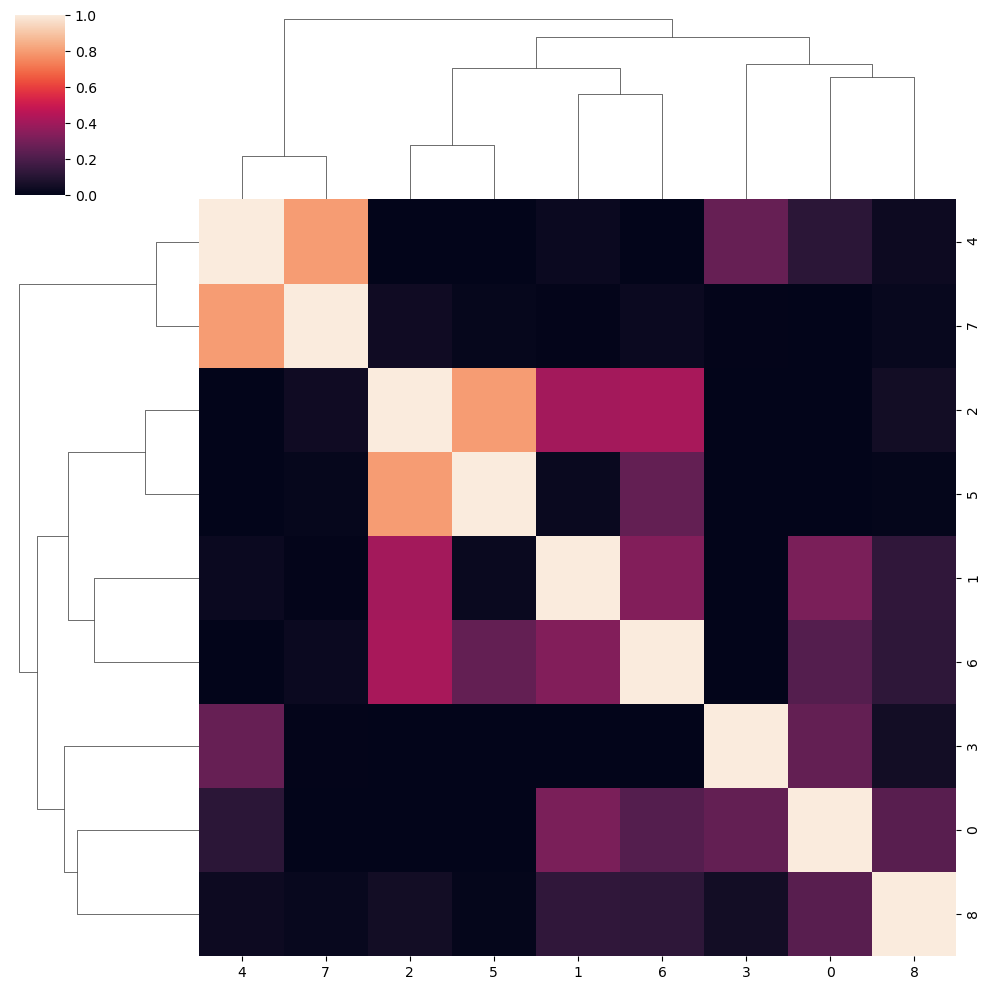

In [153]:
import seaborn as sns
sns.clustermap(norm_sim)

In [76]:
norm_sim = np.identity(norm_sim.shape[0])

In [120]:
norm_sim = torch.tensor(norm_sim)
norm_sim = norm_sim.to(device)

In [121]:
def weighted_loss(probabilities, norm_sim, target):
        probabilities = torch.exp(probabilities)
        similarity = torch.tensor(norm_sim[target,:]).to(device)
        level_loss=-torch.log((probabilities * similarity).sum(axis = 1)).mean()
        return(level_loss)
def check_split(y):
    #chec if all classes are present in both train and test set
    num_classes = len(y.unique()) -1
    assert sum(y[data.train_mask].unique() == y[data.train_mask].unique()) == num_classes
    

In [122]:
check_split(data.y_type)

In [123]:
check_split(data.y_clone)

In [124]:
eps = 1e-4
loss_old = 100
losses = {}
accuracy = {}
losses["clone"] = dict({"train":[],"test":[]})
losses["cell_type"] = dict({"train":[],"test":[]})
accuracy["clone"] = dict({"train":[],"test":[]})
accuracy["cell_type"] = dict({"train":[],"test":[]})
no_improv = 0
for epoch in range(300):
    model.train()
    optimizer.zero_grad()
    pred= model(data.x, data.edge_index)
    pred_clone = pred[:,:data.num_classes_clone-1]
    pred_cell_type = pred[:,data.num_classes_clone-1:]
    pred_clone = F.log_softmax(pred_clone, dim=1)
    pred_cell_type = F.log_softmax(pred_cell_type, dim=1)
    loss_clone = weighted_loss(pred_clone[data.train_mask], norm_sim, data.y_clone[data.train_mask])
    losses["clone"]["train"].append(loss_clone.item())

    # loss_clone = F.nll_loss(pred_clone[data.train_mask], data.y_clone[data.train_mask], weight = weight_clone)
    loss_type = F.nll_loss(pred_cell_type[data.train_mask], data.y_type[data.train_mask], weight = weight_type)
    losses["cell_type"]["train"].append(loss_type.item())
    loss = torch.log(torch.sqrt(loss_clone*loss_type))
    loss.backward()
    optimizer.step()
    
    acc_clone,acc_type, loss_clone_test,loss_ct_test = test()
    if epoch%20==0:
        print(f"epoch {epoch}: Clone prediction loss {loss_clone.item():.3f} \t Cell type prediction loss: {loss_type.item():.3f}")
        print(f"TEST: Clone accuracy {acc_clone:.4f} \t Cell type accuracy: {acc_type:.4f}")
    accuracy["clone"]["test"].append(acc_clone)
    accuracy["cell_type"]["test"].append(acc_type)
    losses["cell_type"]["test"].append(loss_ct_test.detach().cpu().item())
    losses["clone"]["test"].append(loss_clone_test.detach().cpu().item())


    # loss = loss_clone + loss_type

    if (loss_old- loss_clone.item() <eps):
        no_improv += 1
        print(f"no improvement ({no_improv})")
    else:
        no_improv = 0
    if (no_improv >10) & (epoch>100):
        print("EARLY STOPPING")
        break
    loss_old = loss_clone.item()
print("DONE")


/tmp/ipykernel_399/1291163481.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  similarity = torch.tensor(norm_sim[target,:]).to(device)


epoch 0: Clone prediction loss 1.582 	 Cell type prediction loss: 2.216
TEST: Clone accuracy 0.2489 	 Cell type accuracy: 0.1281
epoch 20: Clone prediction loss 0.638 	 Cell type prediction loss: 1.567
TEST: Clone accuracy 0.6743 	 Cell type accuracy: 0.3603
no improvement (1)
no improvement (2)
epoch 40: Clone prediction loss 0.517 	 Cell type prediction loss: 1.310
TEST: Clone accuracy 0.6781 	 Cell type accuracy: 0.5885
epoch 60: Clone prediction loss 0.474 	 Cell type prediction loss: 1.148
TEST: Clone accuracy 0.6581 	 Cell type accuracy: 0.6829
epoch 80: Clone prediction loss 0.454 	 Cell type prediction loss: 1.076
TEST: Clone accuracy 0.6722 	 Cell type accuracy: 0.7209
epoch 100: Clone prediction loss 0.439 	 Cell type prediction loss: 1.032
TEST: Clone accuracy 0.6762 	 Cell type accuracy: 0.7518
no improvement (1)
no improvement (1)
no improvement (1)
epoch 120: Clone prediction loss 0.433 	 Cell type prediction loss: 1.003
TEST: Clone accuracy 0.6793 	 Cell type accuracy: 0

In [122]:
loss_clone_test

tensor(0.0540, device='cuda:0', dtype=torch.float64)

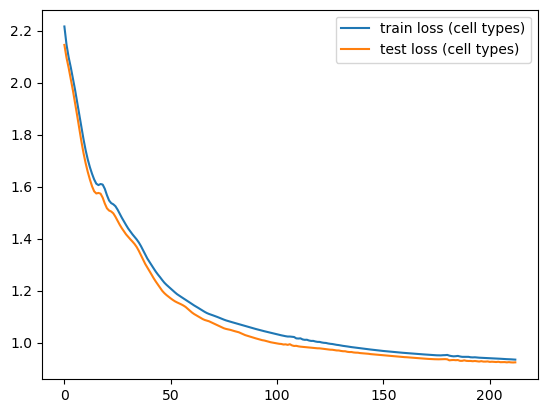

In [125]:
#plt.plot(loss_clones, label = "train loss (clones)")
plt.plot(losses["cell_type"]["train"], label = "train loss (cell types)")
plt.plot(losses["cell_type"]["test"], label = "test loss (cell types)")

plt.legend()
plt.show()

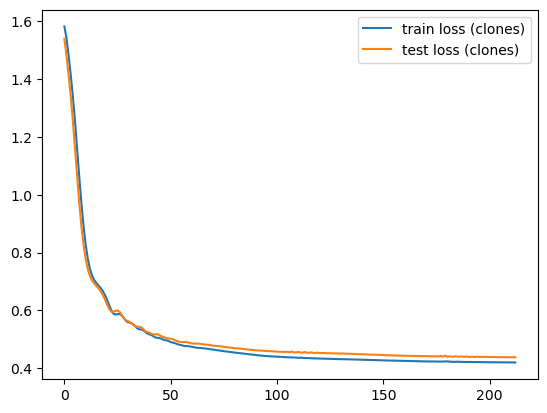

In [126]:
#plt.plot(loss_clones, label = "train loss (clones)")
plt.plot(losses["clone"]["train"], label = "train loss (clones)")
plt.plot(losses["clone"]["test"], label = "test loss (clones)")

plt.legend()
plt.show()

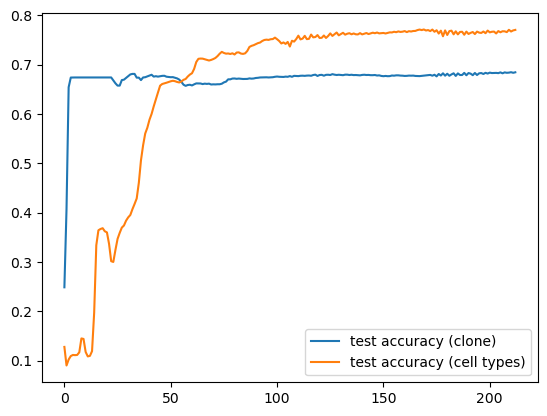

In [127]:
#plt.plot(loss_clones, label = "train loss (clones)")
plt.plot(accuracy["clone"]["test"], label = "test accuracy (clone)")
plt.plot(accuracy["cell_type"]["test"], label = "test accuracy (cell types)")

plt.legend()
plt.show()

In [128]:
model.eval()
pred = model(data.x, data.edge_index)
pred_clone = pred[:,:data.num_classes_clone-1]
pred_cell_type = pred[:,data.num_classes_clone-1:]
pred_clone = F.log_softmax(pred_clone, dim=1)
pred_clone1 = pred_clone.argmax(dim=1)
pred_cell_type = F.log_softmax(pred_cell_type, dim=1)
pred_cell_type1 = pred_cell_type.argmax(dim=1)

correct_clones = (pred_clone1[data.test_mask] == data.y_clone[data.test_mask]).sum()
correct_types = (pred_cell_type1[data.test_mask] == data.y_type[data.test_mask]).sum()

acc_clone = int(correct_clones) / len(data.test_mask)
acc_type = int(correct_types) / len(data.test_mask)

print(f'Accuracy clones: {acc_clone:.4f}')
print(f'Accuracy cell types: {acc_type:.4f}')

Accuracy clones: 0.6848
Accuracy cell types: 0.7707


In [129]:
clone_rev = {val:key for key,val in clone_dict.items()}
type_rev = {val:key for key,val in type_dict.items()}
node_encoder_rev = {val:key for key,val in node_encoder.items()}

In [130]:
pred_clone

tensor([[-1.2001e+01, -1.5787e+01, -3.2445e+01,  ..., -5.7088e+01,
         -4.1281e+01, -6.1989e-06],
        [-7.0783e+01, -5.5659e+01, -1.1218e+02,  ..., -1.0861e+02,
         -7.4490e+01,  0.0000e+00],
        [-1.3137e+01, -1.5480e+01, -2.5064e+01,  ..., -4.1754e+01,
         -2.2170e+01, -9.8943e-06],
        ...,
        [-1.8828e+01, -2.2886e+01, -3.8900e+01,  ..., -5.7322e+01,
         -3.1406e+01,  0.0000e+00],
        [-4.2796e+01, -3.6530e+01, -5.4162e+01,  ..., -6.3023e+01,
         -1.9987e+01, -1.1565e+00],
        [-9.6659e+00, -1.2187e+01, -2.6074e+01,  ..., -5.3981e+01,
         -4.1487e+01, -6.8543e-05]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward0>)

In [131]:
pred = model(data.x, data.edge_index)
pred_clone = pred[:,:data.num_classes_clone-1]
pred_cell_type = pred[:,data.num_classes_clone-1:]
pred_clone = np.exp(F.log_softmax(pred_clone, dim=1).detach().cpu().numpy())
pred_cell_type = np.exp(F.log_softmax(pred_cell_type, dim=1).detach().cpu().numpy())

In [132]:
pred_clone

array([[6.1385076e-06, 1.3922545e-07, 8.1159106e-15, ..., 1.6101212e-25,
        1.1796174e-18, 9.9999386e-01],
       [1.8174710e-31, 6.7255456e-25, 0.0000000e+00, ..., 0.0000000e+00,
        4.4604475e-33, 1.0000000e+00],
       [1.9710076e-06, 1.8933663e-07, 1.3031369e-11, ..., 7.3538910e-19,
        2.3545252e-10, 9.9999011e-01],
       ...,
       [6.6525208e-09, 1.1499755e-10, 1.2761719e-17, ..., 1.2742744e-25,
        2.2936302e-14, 1.0000000e+00],
       [2.5928279e-19, 1.3654562e-16, 3.0053283e-24, ..., 4.2608783e-28,
        2.0870854e-09, 3.1457305e-01],
       [6.3409534e-05, 5.0949357e-06, 4.7438368e-12, ..., 3.6002977e-24,
        9.6036931e-19, 9.9993140e-01]], dtype=float32)

In [133]:
cells_hold_out =[node_encoder_rev[x.item()] for x in data.hold_out]

In [134]:
clone_res = pd.DataFrame(pred_clone[data.hold_out.detach().cpu().numpy()], index = cells_hold_out)

In [135]:
clone_res.columns =list(np.arange(pred_clone.shape[1]))[:-1] + ["diploid"]

In [136]:
ct_res = pd.DataFrame(pred_cell_type[data.hold_out.detach().cpu().numpy()], index = cells_hold_out)
ct_res.columns = [type_rev[x] for x in ct_res.columns]

In [137]:
import scanpy as sc


In [138]:
path = "../data/raw/visium/"
visium = sc.read_visium(path, genome=None, count_file='CytAssist_FFPE_Human_Breast_Cancer_filtered_feature_bc_matrix.h5',
                        library_id=None, load_images=True, source_image_path=None)
visium.var_names_make_unique()

/home/o313a/miniconda3/envs/torch_geo/lib/python3.10/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [139]:
coor_int = [[int(x[0]),int(x[1])] for x in visium.obsm["spatial"]]
visium.obsm["spatial"] = np.array(coor_int)

In [140]:
clones_columns = clone_res.columns
ct_columns = ct_res.columns

In [141]:
visium.obs = visium.obs.join(clone_res).join(ct_res)

In [142]:
visium.obs["clone"] = visium.obs[clones_columns].idxmax(axis = 1)

In [143]:
visium.obs["clone"].unique()

array(['diploid', 0, 2, 4, 1, 6], dtype=object)

In [144]:
visium.obs.clone = visium.obs.clone.astype("str")

In [145]:
import matplotlib as mpl


In [146]:
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):

    sc.pl.spatial(visium, cmap='magma',
                  # show first 8 cell types
                  color=clones_columns,
                  ncols=2, size=1.3,
                  img_key='lowres',
                  # limit color scale at 99.2% quantile of cell abundance
                  vmin=0, vmax='p99.2',
                  show=False
                 )
    #plt.savefig("figures/overclustered_results.png", dpi = 150)

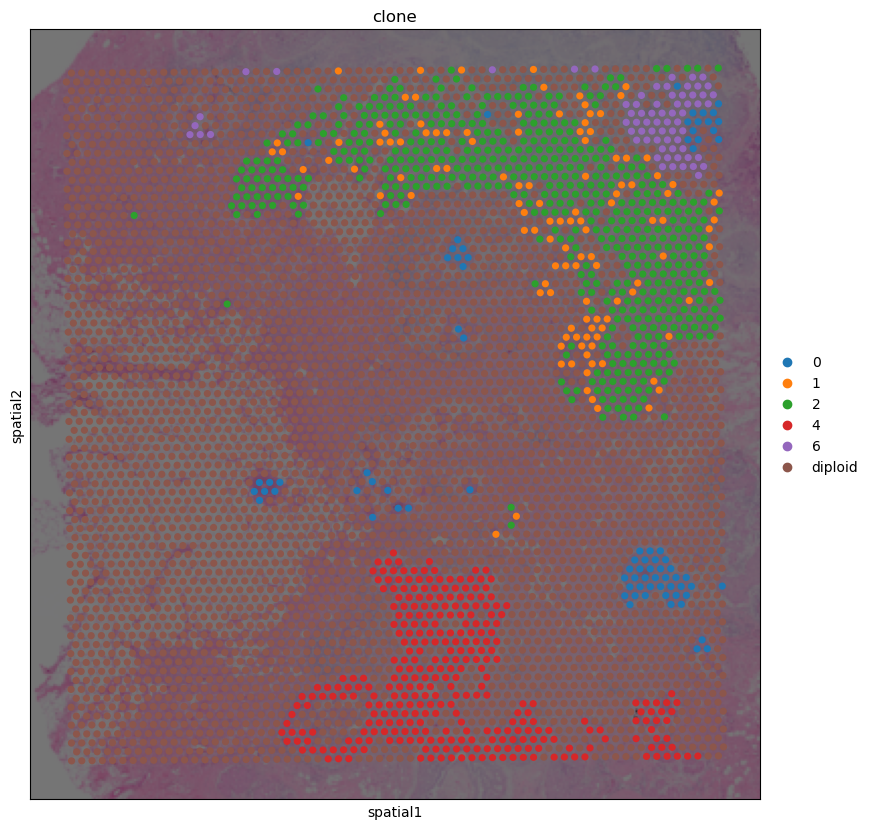

In [147]:
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [10, 10]}):
    sc.pl.spatial(visium, cmap='magma',
                  # show first 8 cell types
                  color="clone",
                img_key='lowres', alpha_img = 0.5,
                 )

In [148]:
visium.obs["cell_type"] = visium.obs[ct_columns].idxmax(axis = 1)

In [149]:
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [10, 10]}):
    sc.pl.spatial(visium, cmap='magma',
                  # show first 8 cell types
                  color="cell_type",
                img_key='lowres', alpha_img = 0.5,
                 )

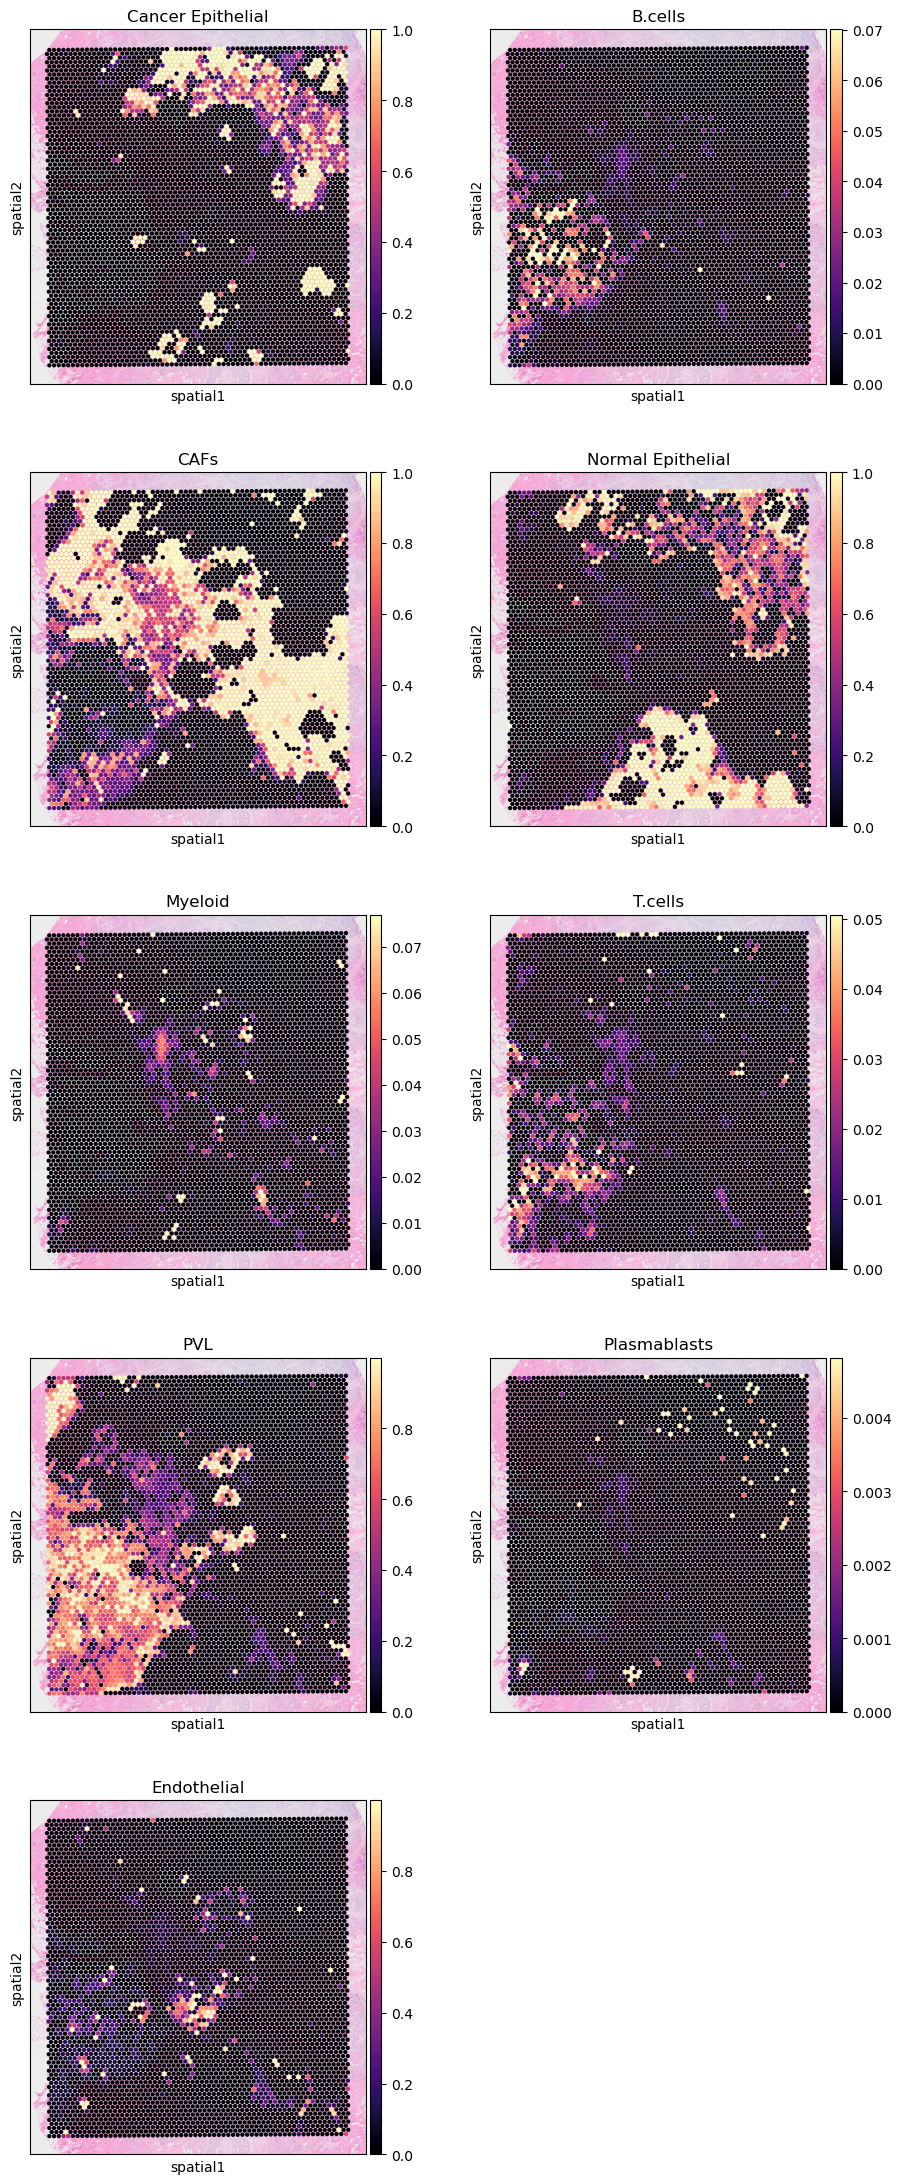

In [198]:
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):

    sc.pl.spatial(visium, cmap='magma',
                  # show first 8 cell types
                  color=ct_columns,
                  ncols=2, size=1.3,
                  img_key='hires',
                  # limit color scale at 99.2% quantile of cell abundance
                  vmin=0, vmax='p99.2',
                  show=False
                 )